In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from sklearn.decomposition import PCA, IncrementalPCA
from tqdm import tqdm

%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import Act2_functions as a2func

### Loading necessary data

In [128]:
data = scipy.io.loadmat('munsell400_700_5.mat')

munsell = data['munsell']
wavelength = np.arange(400,700+5,5)

df_A = pd.read_excel("D65_and_A.xls", skiprows = 5, usecols = [0,1], names = ["wavelength", "illumination"])
df_D65 = pd.read_excel("D65_and_A.xls", skiprows = 5, usecols = [6,7], names = ["wavelength", "illumination"])
df_macbeth = pd.read_excel("MacbethColorChecker.xls", skiprows = 2, usecols = np.arange(0,25))
df_sony = pd.read_excel("Sony_Dxc_930.xlsx").iloc[:, 0].str.split(' ', expand=True)
df_sony.rename(columns={0:'wavelength', 1: 'red', 2: 'green', 3: 'blue'}, inplace=True)
df_sony = df_sony.apply(pd.to_numeric)

df_patches = pd.read_csv('macbeth_SonyDXC-930_F1_.csv', usecols = ['red', 'green', 'blue'])
df_patches['patch'] = np.arange(1,25)

df_A = df_A[(df_A['wavelength'] >= 400) & (df_A['wavelength'] <= 700)]
df_A = df_A.reset_index(inplace=False)
df_A = df_A.drop('index', 1)

df_D65 = df_D65[(df_D65['wavelength'] >= 400) & (df_D65['wavelength'] <= 700)]
df_D65 = df_D65.reset_index(inplace=False)
df_D65 = df_D65.drop('index', 1)

df_fluorescent = pd.read_excel("Fluorescents.xls", skiprows = 1)
df_fluorescent.rename(columns={'Unnamed: 0':'wavelength'}, inplace=True)

df_fluorescentF1 = df_fluorescent[['wavelength', 'F1']]
df_fluorescentF1.rename(columns = {'F1':'illumination'}, inplace = True)

df_fluorescentF1 = df_fluorescentF1[(df_fluorescentF1['wavelength'] >= 400) & (df_fluorescentF1['wavelength'] <= 700)]
df_fluorescentF1 = df_fluorescentF1.reset_index(inplace=False)
df_fluorescentF1 = df_fluorescentF1.drop('index', 1)

df_macbeth = df_macbeth[(df_macbeth['wavelength'] >= 400) & (df_macbeth['wavelength'] <= 700)]
df_macbeth = df_macbeth.reset_index(inplace=False)
df_macbeth = df_macbeth.drop('index', 1)

sony_R = np.interp(wavelength, df_sony.wavelength, df_sony.red)
sony_G = np.interp(wavelength, df_sony.wavelength, df_sony.green)
sony_B = np.interp(wavelength, df_sony.wavelength, df_sony.blue)

df_camera = pd.DataFrame()
df_camera['red'] = sony_R
df_camera['green'] = sony_G
df_camera['blue'] = sony_B

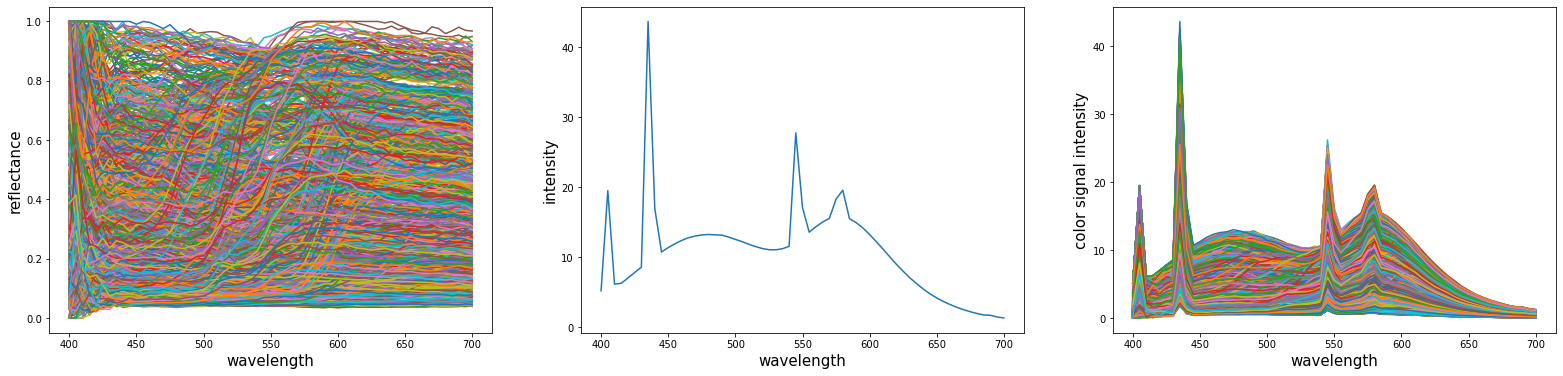

In [28]:
plt.figure(figsize = (9*3,6))
plt.subplot(131)
plt.plot(wavelength, munsell)
#plt.ylim(-0.05,1.05)
plt.ylabel('reflectance', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)

plt.subplot(132)
plt.plot(wavelength, df_fluorescentF1.illumination)
#plt.ylim(-0.05,1.05)
plt.ylabel('intensity', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)

plt.subplot(133)
plt.plot(wavelength, color_signal)
#plt.ylim(-0.05,1.05)
plt.ylabel('color signal intensity', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)

plt.savefig('Figures/input.png', dpi = 300, bbox_inches = 'tight')
plt.show()

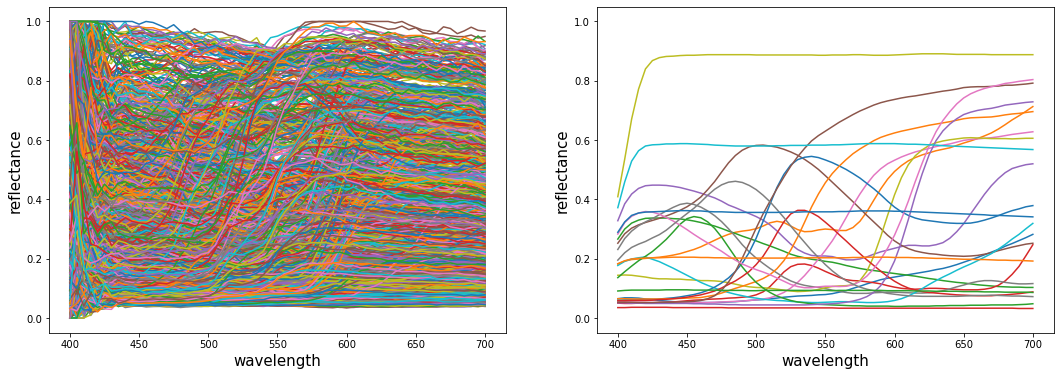

In [24]:
plt.figure(figsize = (9*2,6))

plt.subplot(121)
plt.plot(wavelength, munsell)
plt.ylim(-0.05,1.05)
plt.ylabel('reflectance', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)

plt.subplot(122)
for i in df_macbeth.columns[1:]:
    plt.plot(wavelength, df_macbeth[i])
plt.ylim(-0.050,1.05)
plt.ylabel('reflectance', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)
plt.savefig('Figures/dataset.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [43]:
color_signal.shape

(61, 1250)

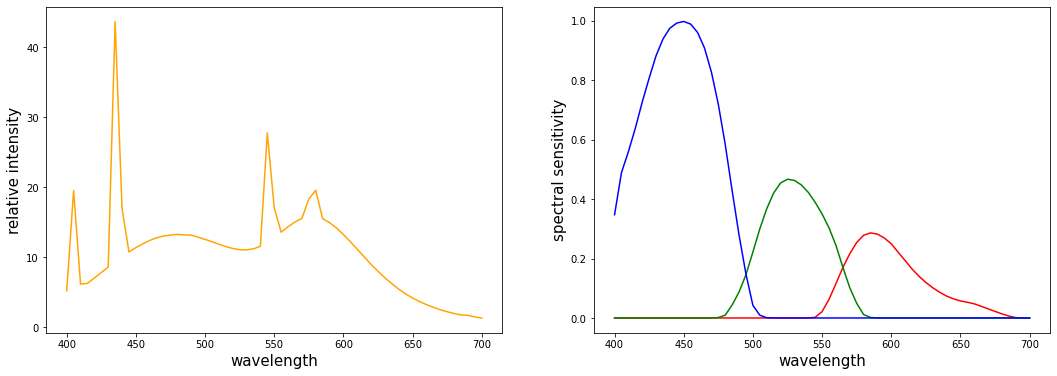

In [25]:
plt.figure(figsize = (9*2,6))

plt.subplot(121)
plt.plot(wavelength, df_fluorescentF1.illumination, color = 'orange')
#plt.ylim(-0.05,1.05)
plt.ylabel('relative intensity', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)

plt.subplot(122)
plt.plot(wavelength, sony_R, color = 'red')
plt.plot(wavelength, sony_G, color = 'green')
plt.plot(wavelength, sony_B, color = 'blue')
plt.ylabel('spectral sensitivity', fontsize = 15)
plt.xlabel('wavelength',fontsize = 15)
plt.savefig('Figures/light_camera.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Apply PCA and record metrics

In [29]:
color_signal = []
for i,j in enumerate(munsell):
    color_signal.append(j * df_fluorescentF1.illumination[i])
color_signal = np.array(color_signal)

In [30]:
pca = PCA(len(color_signal))
pca.fit(color_signal.T)

mean = pca.mean_
evecs = pca.components_
evals = pca.explained_variance_ratio_

explained = pca.explained_variance_ratio_.cumsum() * 100

In [44]:
accuracy = 95
k = np.argmax(explained>accuracy)
print("Number of components explaining 95% variance: "+ str(k+1))

Number of components explaining 95% variance: 3


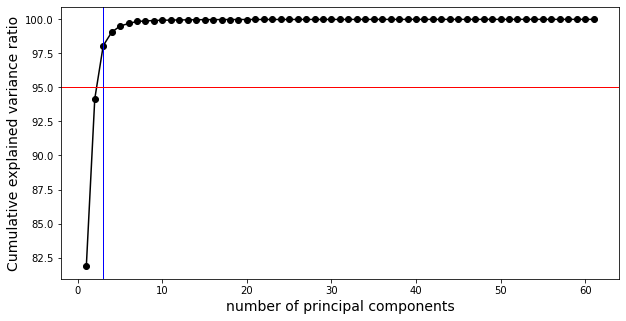

In [45]:
plt.figure(figsize=[10,5])
plt.plot(np.arange(0,len(munsell))+1, explained, 'o-', color = 'black')
plt.ylabel('Cumulative explained variance ratio', fontsize = 14)
plt.xlabel('number of principal components', fontsize = 14)
plt.axvline(x=k+1, color="blue", linewidth = 1)
plt.axhline(y=accuracy, color="red", linewidth = 1)
plt.savefig('Figures/variance_explained.png', bbox_inches = 'tight', dpi = 200)
plt.show()

In [46]:
explained

array([ 81.8488409 ,  94.16235588,  98.06619298,  99.05442216,
        99.50977303,  99.69556563,  99.84612266,  99.88110268,
        99.91326841,  99.93495902,  99.94643623,  99.95702521,
        99.96445381,  99.970736  ,  99.97646045,  99.98064674,
        99.98314836,  99.98545272,  99.98715928,  99.98850964,
        99.98970872,  99.99057948,  99.99124241,  99.99186566,
        99.99247912,  99.99299985,  99.99350239,  99.99397705,
        99.99442621,  99.99486326,  99.99527179,  99.99564947,
        99.99601129,  99.99636074,  99.9966958 ,  99.99702676,
        99.99731679,  99.99759406,  99.99785993,  99.99811284,
        99.99834678,  99.99856745,  99.99878075,  99.9989775 ,
        99.99915491,  99.99932939,  99.99947957,  99.99960409,
        99.99971339,  99.99979305,  99.99985275,  99.99988684,
        99.99991491,  99.99993647,  99.99995245,  99.99996478,
        99.99997452,  99.99998282,  99.99998967,  99.99999523,
       100.        ])

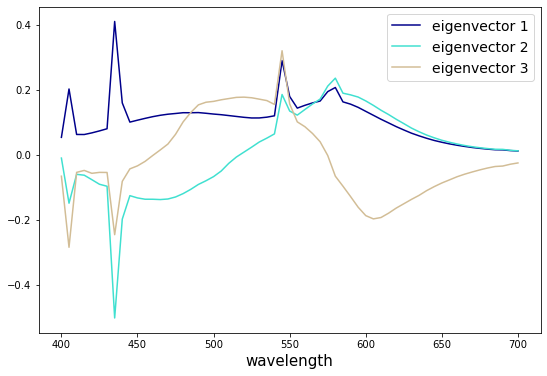

In [51]:
plt.figure(figsize = (9,6))
labels = ['eigenvector 1', 'eigenvector 2', 'eigenvector 3']
colors = ['#00008B', 'Turquoise', '#D2BD96']
for i in range(k+1):
    pc = evecs[i]
    plt.plot(wavelength, pc, color = colors[i], label = labels[i])
plt.legend(fontsize = 14)
plt.xlabel('wavelength',fontsize = 15)
plt.savefig('Figures/principal_components.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Reconstruct Random Color Signals using different PCs

In [34]:
def reconstruct_signal(k, test, mean):
    PC = evecs[0:k,].T
    test_less_mean = test - mean
    a = PC.T @ test_less_mean
    recons = PC @ a
    recons_plus_mean= recons + mean
    return recons_plus_mean

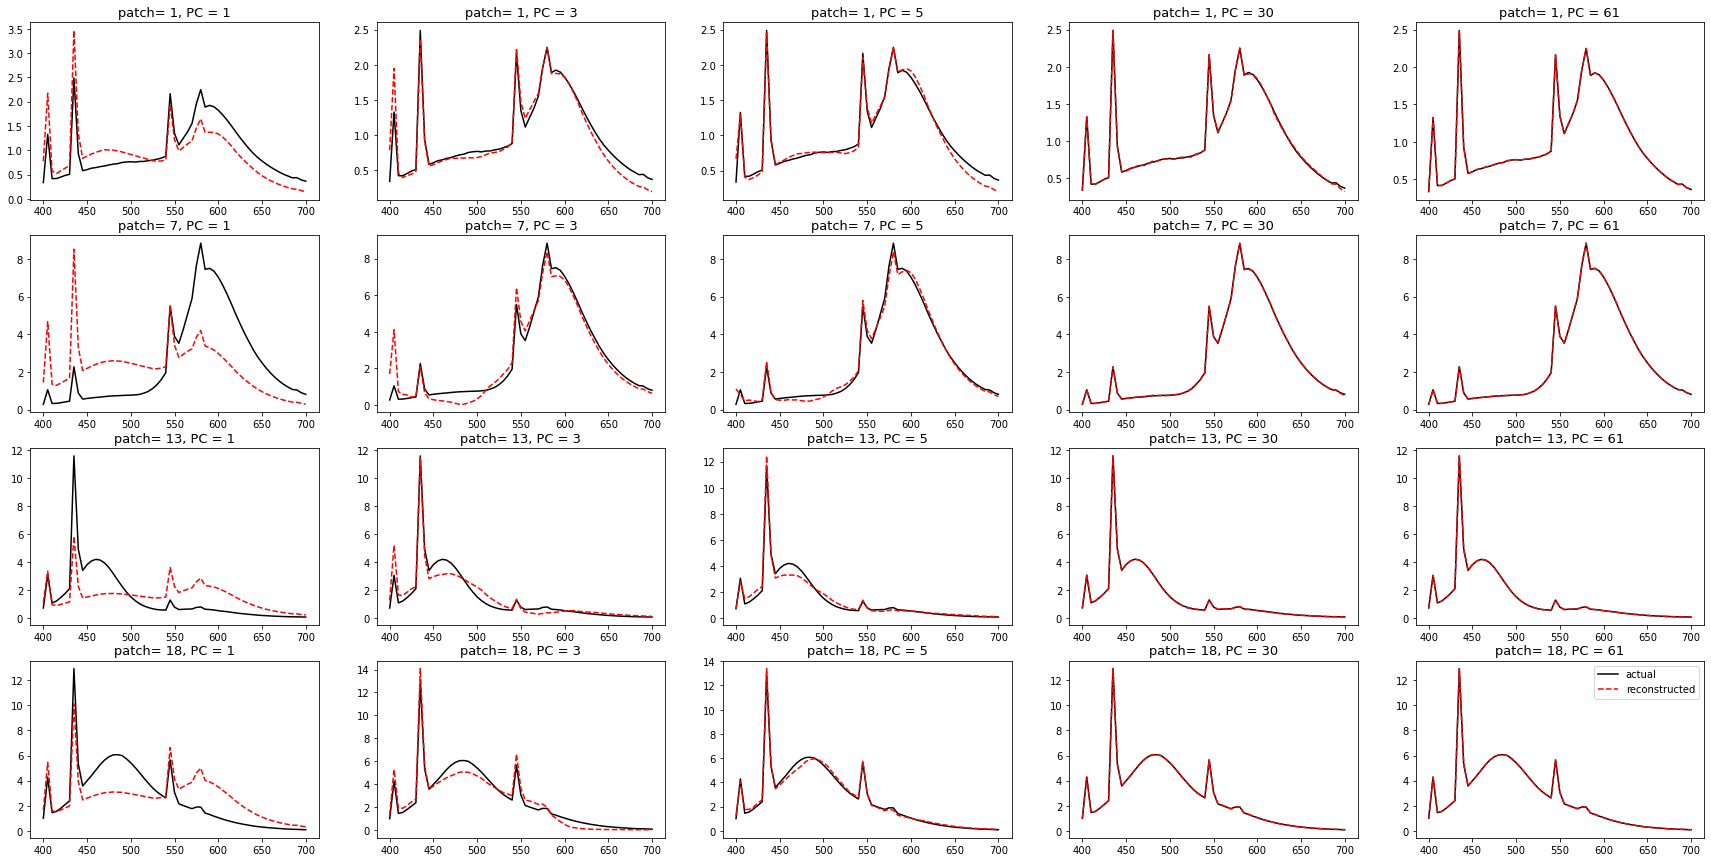

In [55]:
patches = [1,7,13,18]
ks = [1,3,5,30,61]

plt.figure(figsize = (30,15))
for i,j in enumerate(patches):
    test_signal = df_macbeth[j] * df_fluorescentF1.illumination
    for m,n in enumerate(ks):
        reconstructed_signal = reconstruct_signal(n,test_signal,mean)
        plt.subplot(4,5, m+1+(5*i))
        plt.plot(wavelength, test_signal, color = 'black', label = 'actual')
        plt.plot(wavelength, reconstructed_signal, color = 'red', linestyle = '--', label = 'reconstructed')
        plt.title('patch= '+str(j)+', PC = '+str(n), fontsize = 13)
plt.legend()
plt.savefig('Figures/random_reconstucted.png', dpi = 300, bbox_inches='tight')
plt.show()

### Compare RMSE and SSIM

In [37]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity

In [40]:
RMSE = np.zeros((24,len(munsell)))
SSIM = np.zeros((24,len(munsell)))

for i,j in tqdm(enumerate(df_macbeth.columns[1:])):
    test_signal = df_macbeth[j] * df_fluorescentF1.illumination
    rmse = []
    ssim = []
    for component in range(len(munsell)):
        reconstructed_signal = reconstruct_signal(component+1,test_signal,mean)
        rmse_val = np.sqrt(mean_squared_error(test_signal,reconstructed_signal))
        ssim_val = structural_similarity(test_signal, reconstructed_signal)
        rmse.append(rmse_val)
        ssim.append(ssim_val)
    RMSE[i] = np.array(rmse)
    SSIM[i] = np.array(ssim)

24it [00:01, 16.36it/s]


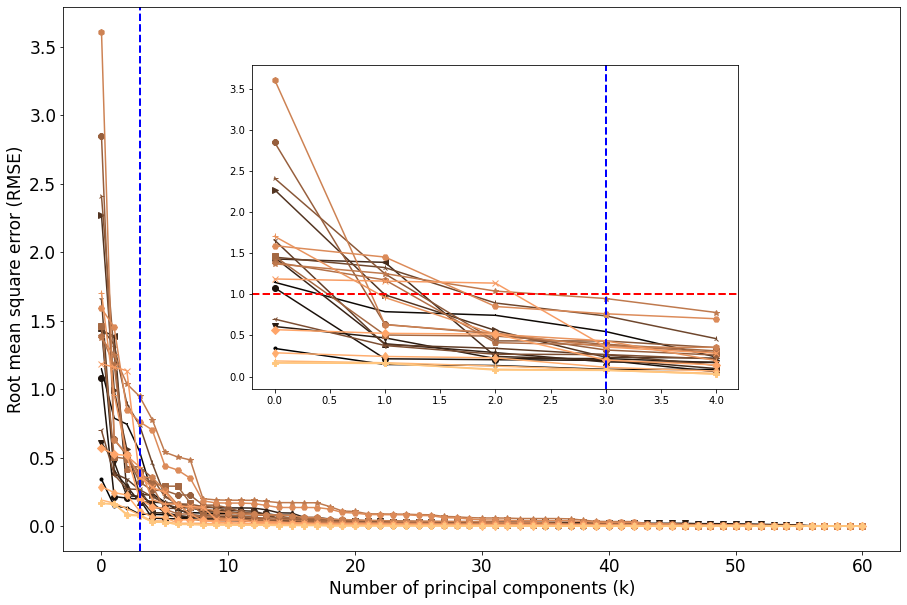

In [126]:
from matplotlib.lines import Line2D
markers = list(Line2D.markers.keys())[0:24]

fig, ax1 = plt.subplots(figsize = (15,10))

left, bottom, width, height = [0.3, 0.35, 0.45, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])
colors = plt.cm.copper(np.linspace(0,1,len(RMSE)))
for i, j in enumerate(RMSE):
    ax1.plot(j, color = colors[i], marker = markers[i])
    ax2.plot(j[0:5], color = colors[i], marker = markers[i])

ax1.set_xlabel("Number of principal components (k)", fontsize = 17)
ax1.set_ylabel("Root mean square error (RMSE)", fontsize = 17)
#ax2.set_yscale('log')
#ax1.legend(fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.axvline(x=k+1, color="blue", linewidth = 2, linestyle='dashed')
ax2.axvline(x=k+1, color="blue", linewidth = 2, linestyle='dashed')
ax2.axhline(y = 1, color = 'red', linewidth = 2, linestyle = 'dashed')
plt.savefig('Figures/RMSE_act4.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Macbeth chart reconstruction

In [123]:
def color_output(wavelength,C, P, R, Sr, Sg, Sb): 
    Cr = sum(C* Sr) / sum(P * Sr)
    Cg = sum(C* Sg) / sum(P * Sg)
    Cb = sum(C * Sb) / sum(P * Sb)
    
    C = [Cr, Cg, Cb]
    
    return C

In [124]:
def visualize_color(intensity, color):
    output = np.zeros([10,10,3])
    output[:,:,0] = int(color[0]*intensity)
    output[:,:,1] = int(color[1]*intensity)
    output[:,:,2] = int(color[2]*intensity)
    output = output.astype(int)
    
    plt.imshow(output)
    plt.axis('off')
    plt.title('RGB: (' + str(int(color[0]*intensity)) + ',' + str(int(color[1]*intensity)) + ',' + str(int(color[2]*intensity)) + ')', fontsize=15)
    plt.show()

In [142]:
def recreate_image(df_camera, df_object, df_light_source, intensity,k):
    N = 24 #number of macbeth colors
    macbeth = np.zeros([N,N,3])
    colors = []
    for i in [i for i in df_object.columns][1:]:
        color_signal = df_object[i] * df_light_source.illumination
        if k == 0: color_signal_recons = color_signal
        if k != 0: color_signal_recons = reconstruct_signal(k,color_signal,mean)
        color = color_output(wavelength, color_signal_recons, df_light_source.illumination, df_object[i], df_camera.red, df_camera.green, df_camera.blue)
        colors.append(color)
    
    colors = np.array(colors)    
    macbeth[:,:,0] = colors[:,0] * intensity
    macbeth[:,:,1] = colors[:,1] * intensity
    macbeth[:,:,2] = colors[:,2] * intensity

    macbeth = macbeth.astype(int)

    array1 = np.array([macbeth[0][0:6]])
    array2 = np.array([macbeth[0][6:12]])
    array3 = np.array([macbeth[0][12:18]])
    array4 = np.array([macbeth[0][18:24]])

    array_camera = np.vstack((array1,array2, array3, array4))
    array_camera[array_camera > 255] = 255
        
    return array_camera

def recreate_macbeth(array):
    #plt.figure(figsize=[9,6])
    plt.imshow(array)
    for i in range(5):
        plt.axhline(y=-0.5+i, color='black', linewidth = 5)
    for j in range(7):
        plt.axvline(x=-0.5+j, color='black', linewidth = 5)

    plt.axhline(y=-0.5, color='black', linewidth = 10)
    plt.axhline(y=3.5, color='black', linewidth = 10)
    plt.axvline(x=-0.5, color='black', linewidth = 10)
    plt.axvline(x=5.5, color='black', linewidth = 10)
    plt.axis('off')

In [137]:
for i, names in enumerate(camera_light_names):    
    array_macbeth = recreate_image(df_camera, df_macbeth, df_fluorescentF1, 255 + 33, 1)
    plt.subplot(2,5,i+1)
    recreate_macbeth(array_macbeth)
    plt.title("Camera: "+str(names[0])+ ", light: "+str(names[1]), fontsize = 15)

plt.subplots_adjust(wspace=0.1, hspace=0.01)
#plt.savefig('Figures/rendered_macbeth_with_white_balance.png', bbox_inches = 'tight', dpi = 300)
plt.show()

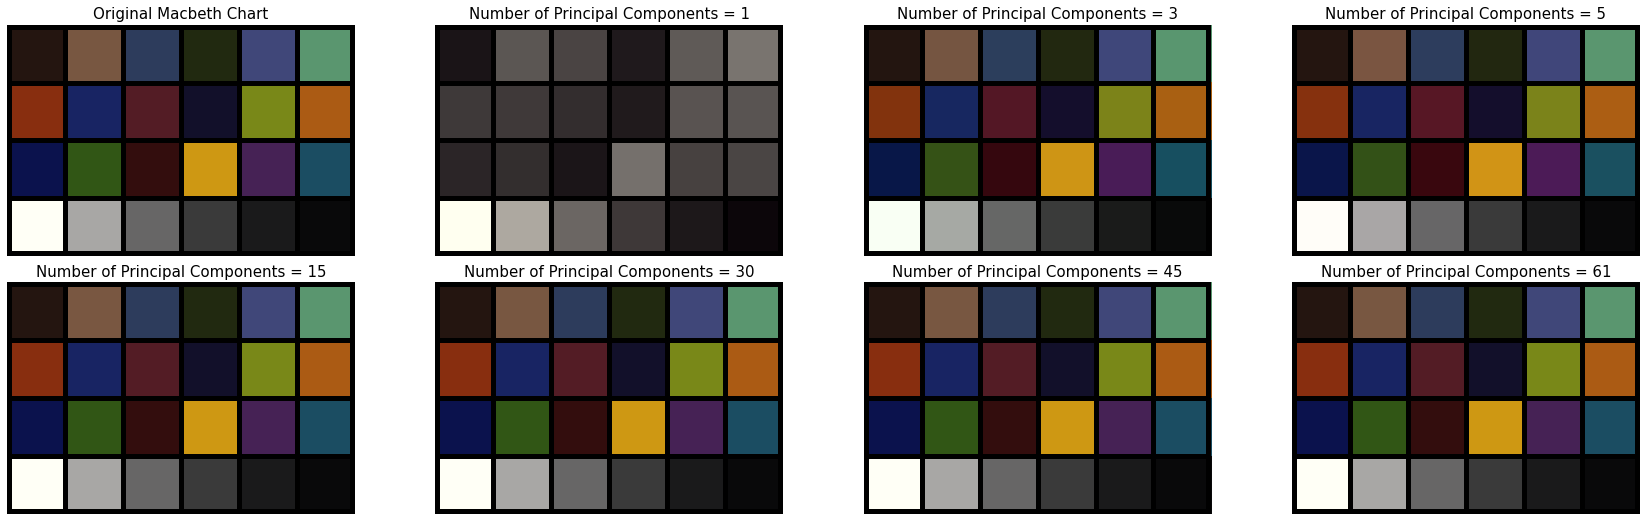

In [166]:
ks = [0,1,3,5,15,30,45,61]

plt.figure(figsize = (6*5,6*1.5))
for i,j in enumerate(ks):
    array_macbeth = recreate_image(df_camera, df_macbeth, df_fluorescentF1, 255 + 33, j)
    plt.subplot(2,4,i+1)
    recreate_macbeth(array_macbeth)
    if j == 0: plt.title("Original Macbeth Chart", fontsize = 15)
    else:
        plt.title("Number of Principal Components = "+str(j), fontsize = 15)
plt.subplots_adjust(wspace=0.1, hspace=0.11)
plt.savefig('Figures/macbeth_chart.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [196]:
def create_dataframe(k):
    array_macbeth_orig = recreate_image(df_camera, df_macbeth, df_fluorescentF1, 255 + 33, k)
    array_macbeth_orig = array_macbeth_orig.reshape(1,24,3)[0]
    df_orig = pd.DataFrame()
    df_orig['red'] = array_macbeth_orig[:,0]
    df_orig['green'] = array_macbeth_orig[:,1]
    df_orig['blue'] = array_macbeth_orig[:,2]
    
    return df_orig

def distance(df_A, df_B):
    d = np.sqrt((df_A.red - df_B.red)**2 + (df_A.green - df_B.green)**2 + (df_A.blue - df_B.blue)**2)
    return d/np.sqrt((255)**2+(255)**2+(255)**2) * 100

In [240]:
df_original = create_dataframe(0)

In [241]:
comp = 3
df_best = create_dataframe(3)

In [242]:
d = distance(df_original, df_best)

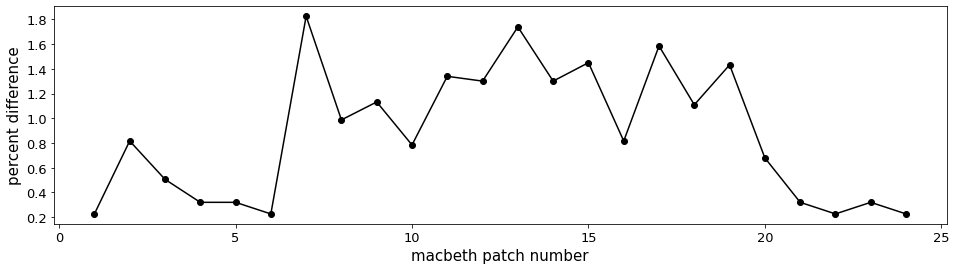

In [245]:
plt.figure(figsize = (16,4))
plt.plot(df_macbeth.columns[1:], d, 'ko-')
plt.xlabel('macbeth patch number', fontsize = 15)
plt.ylabel('percent difference', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig('Figures/color_difference_1D.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [201]:
color_diff = np.zeros((61,24))

In [202]:
for i in range(61):
    df_best = create_dataframe(i + 1)
    d = distance(df_original, df_best)
    
    color_diff[i] = d

/tmp/ipykernel_16169/3960621380.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(color_diff), cmap = plt.cm.copper,  extent = [0, 24, 0, 61], aspect = 0.40, origin = 'lower')


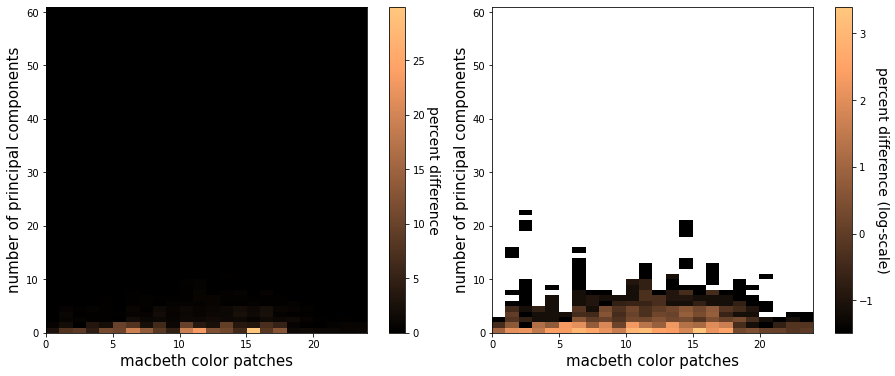

In [251]:
plt.figure(figsize = (8*2,6))
plt.subplot(121)
plt.imshow(color_diff, cmap = plt.cm.copper,  extent = [0, 24, 0, 61], aspect = 0.40, origin = 'lower')
plt.xlabel('macbeth color patches', fontsize = 15)
plt.ylabel('number of principal components', fontsize = 15)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('percent difference', rotation=270, fontsize = 14)

plt.subplot(122)
plt.imshow(np.log(color_diff), cmap = plt.cm.copper,  extent = [0, 24, 0, 61], aspect = 0.40, origin = 'lower')
plt.xlabel('macbeth color patches', fontsize = 15)
plt.ylabel('number of principal components', fontsize = 15)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('percent difference (log-scale)', rotation=270, fontsize = 14)
plt.subplots_adjust(wspace=0.0, hspace=0.11)
plt.savefig('Figures/color_difference_2D.png', dpi = 300, bbox_inches = 'tight')
plt.show()